# Learing pipeline

Miguel Xochicale [@mxochicale](https://github.com/mxochicale)  
Feb2022


## 1 Introduction
This notebook presents prototypes to pre-process echocardiography datasets with the use of pytorch features. 

### 1.1 Running notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### 1.2 References
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 




## 2. Jupyter Notebook

### 2.1 Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from typing import Dict, List, Tuple

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.models.learning_misc import train_loop, test_loop, BasicCNNClassifier, TestNet
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes

HOME_PATH = os.path.expanduser(f'~')
CONFIG_FILES_PATH= 'repositories/echocardiography/scripts/config_files/learning_pipeline'
YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, 'config_learning_pipeline.yml')

yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler

with open(YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)
    
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)    


PyTorch Version:  1.9.0
Torchvision Version:  0.10.0a0


### 2.2 Setting variables and loading datasets using pytorch dataloader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=config['pretransform_im_size']),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 80% of total datasets
train_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=train_transform,
    use_tmp_storage=True,
    )

#### 20% of total datasets
validation_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=val_transform,
    use_tmp_storage=True,
    )


## Spliting train_dataset into train_set and test_set
Ntdt = train_dataset.__len__()
ntraining = 0.8

Ntrain=round(Ntdt*ntraining)
Ntest = round(Ntdt - (Ntdt*ntraining))
print(Ntrain, Ntest, Ntrain+Ntest)
train_set, test_set = torch.utils.data.random_split(train_dataset, [Ntrain, Ntest])



[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-074/T3/01NVb-003-074-3-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T1/01NVb-003-077-1-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T2/01NVb-003-077-2-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T3/01NVb-003-077-3-4CV.json (empty). Removing from list
58 14 72


### 2.3 Plotting Class Distribution


{'BKGR': 28, '4CV': 30}
{'BKGR': 8, '4CV': 8}


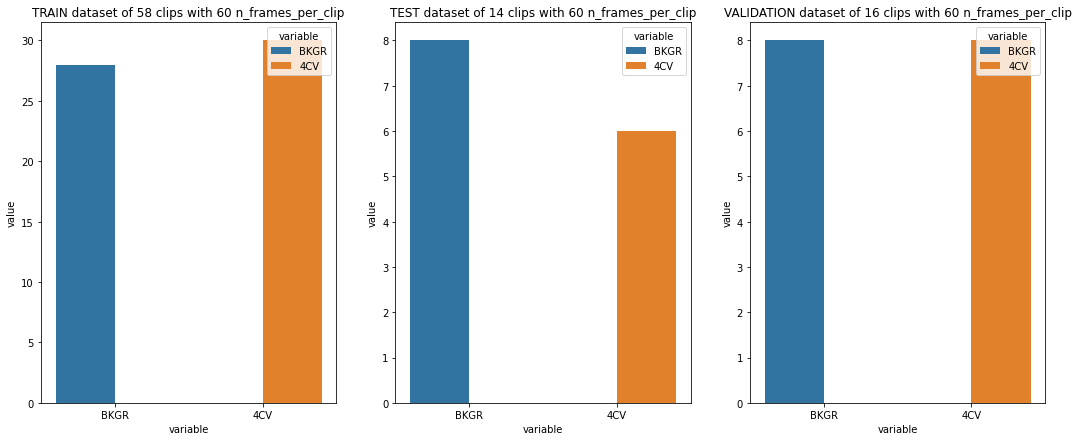

In [3]:
label_id = ('BKGR', '4CV')
number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip'] 

def get_class_distribution(dataset_obj):
    count_class_dict = {
   'BKGR': 0 ,
   "4CV": 0
    }
    
    for clip_index_i in range(len(dataset_obj)):
        data_idx = dataset_obj[clip_index_i]
        label_id_idx = data_idx[1]
        label = label_id[label_id_idx]
        count_class_dict[label]+= 1
        #count_class_dict[label]+= 1* number_of_frames_per_segment_in_a_clip

    return count_class_dict
        
        
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), 
                       x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


print(get_class_distribution(train_set))
print(get_class_distribution(validation_dataset))

plot_title_train_label= f'TRAIN dataset of {len(train_set)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_set)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(validation_dataset)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(get_class_distribution(train_set), plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(get_class_distribution(test_set), plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(get_class_distribution(validation_dataset), plot_title=plot_title_val_label, ax=axes[2])
plt.show()



### 2.4 Animating frames of one clip of the dataloader

Clip Size of data_clip_idx torch.Size([60, 1, 128, 128]) of 4CV label


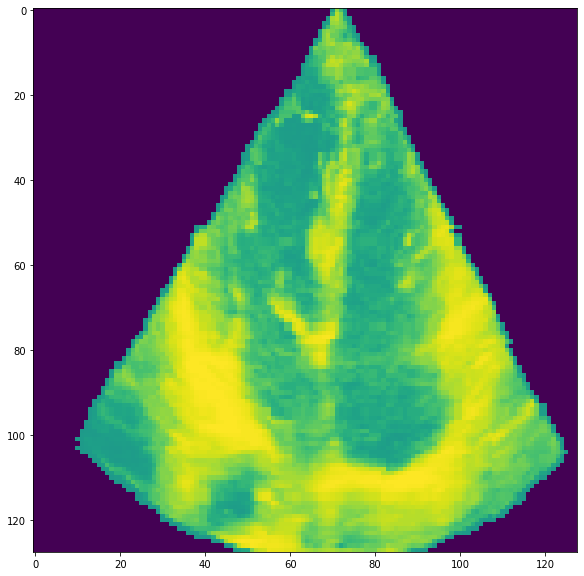

In [4]:
#average_HR =
#fps = 30
# 60 # beats per minute 
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

clip_idx = 21
data_clip_idx = train_set[clip_idx][0]
data_clip_label = train_set[clip_idx][1]
print(f'Clip Size of data_clip_idx {data_clip_idx.size()} of {label_id[data_clip_label]} label')

### Animating data_clip_idx 
interval_between_frames_in_milliseconds=200
fig = plt.figure(figsize=(10, 10))
frames = [[plt.imshow(data_clip_idx[i].cpu().detach().numpy().transpose(1, 2, 0))] for i in range(len(data_clip_idx))]
anim = animation.ArtistAnimation(fig, frames, interval=interval_between_frames_in_milliseconds, blit=True, repeat_delay=1000)

HTML(anim.to_jshtml())

# ### Save animation as gif (if required) or other formats https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/
# f = r"/home/mx19/repositories/echocardiography/scripts/learning-pipeline/animation.gif" 
# writergif = animation.PillowWriter(fps=30) 
# writergif2='imagemagick'
# anim.save(f, dpi=80, writer=writergif)


### 2.5 Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
3. Set the number of clips per batch


In [5]:
##############################
##### Setting up Model Parameters

LEARNING_RATE = 0.000005
MAX_EPOCHS = 500 #Alternatvely, make use of: config['max_epochs']
BATCH_SIZE_OF_CLIPS = 10


model = BasicCNNClassifier(config['pretransform_im_size']) #print(config['pretransform_im_size']) #(128, 128)
model.to(device)


## PRINT MODEL
print(f'====================================================')
print(model)

### PRINT model.named_parameters
print(f'====================================================')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
    
        
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()


BasicCNNClassifier(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=983040, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=2, bias=True)
    (4): Sigmoid()
  )
)
classifier.1.weight tensor([[ 2.2963e-05,  6.8308e-04, -5.4778e-04,  ..., -4.8568e-05,
         -1.0028e-03,  9.5242e-04],
        [ 4.6566e-04, -3.9274e-04, -2.0455e-04,  ...,  7.9947e-04,
          4.7173e-04, -7.7161e-04],
        [-7.0422e-04,  5.2223e-04, -8.8215e-04,  ...,  2.3031e-04,
         -1.1927e-04,  8.2255e-04],
        ...,
        [-4.8102e-04,  9.9474e-04,  8.0054e-04,  ...,  7.2583e-04,
          3.2438e-04, -1.2153e-04],
        [ 3.6062e-04, -3.5422e-05, -9.7454e-04,  ..., -5.5494e-04,
          5.9288e-04,  3.5201e-04],
        [ 6.0476e-04,  5.6271e-04, -8.3122e-04,  ...,  3.5083e-04,
         -5.6463e-04, -3.4933e-04]], device='cuda:0')
classifier.1.bias tensor([ 1.0509e-05, -9.5136e-04,  5.7585e-04, -5.6196e-04,

### 2.6 Displayting frames in the dataloader

In [6]:
print(f' train_dataset.__len__() = {train_set.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)


print(f' test_dataset.__len__() = {test_set.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)



print(f' validation_dataset.__len__() = {validation_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)



for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
    print(f'SAMPLE_IDX_LABELS: {  sample_batched_labels  }')
    print(f'SAMPLE_BATCH: {sample_batched_images.size()}')
    
    sample_batched=sample_batched_images #.squeeze()
    print(f'SAMPLE_BATCH.squeeze: {sample_batched.size()}')
    
    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'   BATCH_SIZE_IDX {BATCH_SIZE_IDX} label: {label}')
        sample_batched_idx_image = sample_batched[BATCH_SIZE_IDX,...]
        print(f'   Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )
        
        grid = utils.make_grid(sample_batched_idx_image)
        print(f'   Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()



 train_dataset.__len__() = 58
 test_dataset.__len__() = 14
 validation_dataset.__len__() = 16
BATCH_OF_CLIPS_INDEX: 0 
SAMPLE_IDX_LABELS: tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 1])
SAMPLE_BATCH: torch.Size([10, 60, 1, 128, 128])
SAMPLE_BATCH.squeeze: torch.Size([10, 60, 1, 128, 128])
   BATCH_SIZE_IDX 0 label: 1
   Sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
   BATCH_SIZE_IDX 1 label: 1
   Sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
   BATCH_SIZE_IDX 2 label: 1
   Sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
   BATCH_SIZE_IDX 3 label: 1
   Sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
   BATCH_SIZE_IDX 4 label: 1
   Sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
   BATCH_SIZE_IDX 5 label: 0
   Sample_

### 2.7 Training loop

In [7]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)


#Dictionaries to store the accuracy/epoch and loss/epoch for both train and validation sets.
loss_stats = {
    'train': [],
    'test': [],
    #"val": []
}
accuracy_stats = {
    #'train': [],
    'test': [],
    #"val": []
}

#for epoch in tqdm(range(1, MAX_EPOCHS)):   
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    #train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc = train_validation_loop(train_dataloader, val_dataloader, model, criterion, optimizer, device)
    #train_epoch_loss, train_epoch_acc = 
    train_epoch_loss = train_loop(train_dataloader, model, criterion, optimizer, device)
    model.eval()
    test_epoch_loss, correct = test_loop(val_dataloader, model, criterion, device)

    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} | Average Train Acc: {train_epoch_acc:.5f} | Average Validation Loss: {val_epoch_loss:.3f} | Average Validation Acc: {val_epoch_acc:.5f} ')
    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} |Average Train Acc: {train_epoch_acc:.5f}  ')
    
    
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_epoch_loss:>8f} \n")

    print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} ')
    print(f"Test Error: \n Test Accuracy: {(100*correct):>0.1f}%, Avg Test loss: {test_epoch_loss:>8f} \n")
    
    loss_stats['train'].append(train_epoch_loss)
    loss_stats['test'].append(test_epoch_loss)    
    accuracy_stats['test'].append(100*correct)
            
print("DONE TRAINING LOOP!")



model_path = '/home/mx19/tmp/model' 
print(f' {model_path}')
torch.save(model.state_dict(), os.path.join(model_path, "metric_model.pth"))
print("Saved metric model")


print(loss_stats)
print(accuracy_stats)


----------
EPOCH 1/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 00: | Average Train Loss: 0.714 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.693852 

----------
EPOCH 2/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 01: | Average Train Loss: 0.701 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.694563 

----------
EPOCH 3/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 02: | Average Train Loss: 0.714 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.692754 

----------
EPOCH 4/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_

 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 29: | Average Train Loss: 0.675 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.681880 

----------
EPOCH 31/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 30: | Average Train Loss: 0.690 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.669784 

----------
EPOCH 32/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 31: | Average Train Loss: 0.676 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.670875 

----------
EPOCH 33/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 32: | Average Train Loss: 0.680 
Test Error: 
 

 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 58: | Average Train Loss: 0.651 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.666807 

----------
EPOCH 60/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 59: | Average Train Loss: 0.652 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.685366 

----------
EPOCH 61/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 60: | Average Train Loss: 0.653 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.652397 

----------
EPOCH 62/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 61: | Average Train Loss: 0.659 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.683293 

----

 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 88: | Average Train Loss: 0.603 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.666489 

----------
EPOCH 90/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 89: | Average Train Loss: 0.647 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.663660 

----------
EPOCH 91/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 90: | Average Train Loss: 0.613 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.652255 

----------
EPOCH 92/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
E

 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 117: | Average Train Loss: 0.601 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.637366 

----------
EPOCH 119/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 118: | Average Train Loss: 0.615 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.643870 

----------
EPOCH 120/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 119: | Average Train Loss: 0.606 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.660398 

----------
EPOCH 121/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 120: | Average 

 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 146: | Average Train Loss: 0.593 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.596699 

----------
EPOCH 148/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 147: | Average Train Loss: 0.577 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.636557 

----------
EPOCH 149/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 148: | Average Train Loss: 0.613 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.656157 

----------
EPOCH 150/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 149: | Average Train Loss: 0.604 
Test Er

 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 175: | Average Train Loss: 0.591 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.647992 

----------
EPOCH 177/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 176: | Average Train Loss: 0.588 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.606628 

----------
EPOCH 178/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 177: | Average Train Loss: 0.577 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.631905 

----------
EPOCH 179/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 178: | Average Train Loss: 0.598 
Test Error: 
 Test Accuracy: 68.8

 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 204: | Average Train Loss: 0.587 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.623678 

----------
EPOCH 206/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 205: | Average Train Loss: 0.544 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.634026 

----------
EPOCH 207/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 206: | Average Train Loss: 0.632 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.652533 

----------
EPOCH 208/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 207: | Average Train Loss: 0.603 
Test Error: 
 Test Accuracy: 62.5

 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 233: | Average Train Loss: 0.583 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.583986 

----------
EPOCH 235/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 234: | Average Train Loss: 0.588 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.627261 

----------
EPOCH 236/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 235: | Average Train Loss: 0.556 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.608774 

----------
EPOCH 237/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 236: | Average Train Loss: 0.543 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.586986

 BATCH_OF_CLIPS_INDEX: 5 
Epoch 262: | Average Train Loss: 0.581 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.595370 

----------
EPOCH 264/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 263: | Average Train Loss: 0.548 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.623832 

----------
EPOCH 265/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 264: | Average Train Loss: 0.551 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.624687 

----------
EPOCH 266/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 265: | Average Train Loss: 0.587 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.610589 

----------
EPOCH 267/50

Epoch 291: | Average Train Loss: 0.535 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.672931 

----------
EPOCH 293/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 292: | Average Train Loss: 0.563 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.625453 

----------
EPOCH 294/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 293: | Average Train Loss: 0.588 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.604260 

----------
EPOCH 295/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 294: | Average Train Loss: 0.557 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.584579 

----------
EPOCH 296/500
 BATCH_OF_CLIPS_INDEX: 0

Epoch 320: | Average Train Loss: 0.566 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.631262 

----------
EPOCH 322/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 321: | Average Train Loss: 0.561 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.586618 

----------
EPOCH 323/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 322: | Average Train Loss: 0.564 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.594110 

----------
EPOCH 324/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 323: | Average Train Loss: 0.560 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.583420 

----------
EPOCH 325/500
 BATCH_OF_CLIPS_INDEX: 0

 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 350: | Average Train Loss: 0.588 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.617700 

----------
EPOCH 352/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 351: | Average Train Loss: 0.589 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.605948 

----------
EPOCH 353/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 352: | Average Train Loss: 0.571 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.589114 

----------
EPOCH 354/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX

 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 379: | Average Train Loss: 0.578 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.585836 

----------
EPOCH 381/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 380: | Average Train Loss: 0.583 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.650998 

----------
EPOCH 382/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 381: | Average Train Loss: 0.575 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.618093 

----------
EPOCH 383/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 382: | Average 

 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 408: | Average Train Loss: 0.545 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.580007 

----------
EPOCH 410/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 409: | Average Train Loss: 0.553 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.630335 

----------
EPOCH 411/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 410: | Average Train Loss: 0.540 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.606880 

----------
EPOCH 412/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 411: | Average Train Loss: 0.564 
Test Er

 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 437: | Average Train Loss: 0.529 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.578552 

----------
EPOCH 439/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 438: | Average Train Loss: 0.543 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.636040 

----------
EPOCH 440/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 439: | Average Train Loss: 0.615 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.596748 

----------
EPOCH 441/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 440: | Average Train Loss: 0.552 
Test Error: 
 Test Accuracy: 75.0

 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 466: | Average Train Loss: 0.522 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.629117 

----------
EPOCH 468/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 467: | Average Train Loss: 0.565 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.561345 

----------
EPOCH 469/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 468: | Average Train Loss: 0.595 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.568183 

----------
EPOCH 470/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 469: | Average Train Loss: 0.567 
Test Error: 
 Test Accuracy: 75.0

 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 495: | Average Train Loss: 0.566 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.590460 

----------
EPOCH 497/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 496: | Average Train Loss: 0.551 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.591789 

----------
EPOCH 498/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 497: | Average Train Loss: 0.502 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.604327 

----------
EPOCH 499/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 498: | Average Train Loss: 0.515 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.626789

## 2.8 Visualize Loss and Accuracy

Text(0.5, 1.0, 'Train-Val Accuracy/Epoch EPOCHS=500 BATCH_SIZE_OF_CLIPS=10 LEARNING_RATE=5e-06')

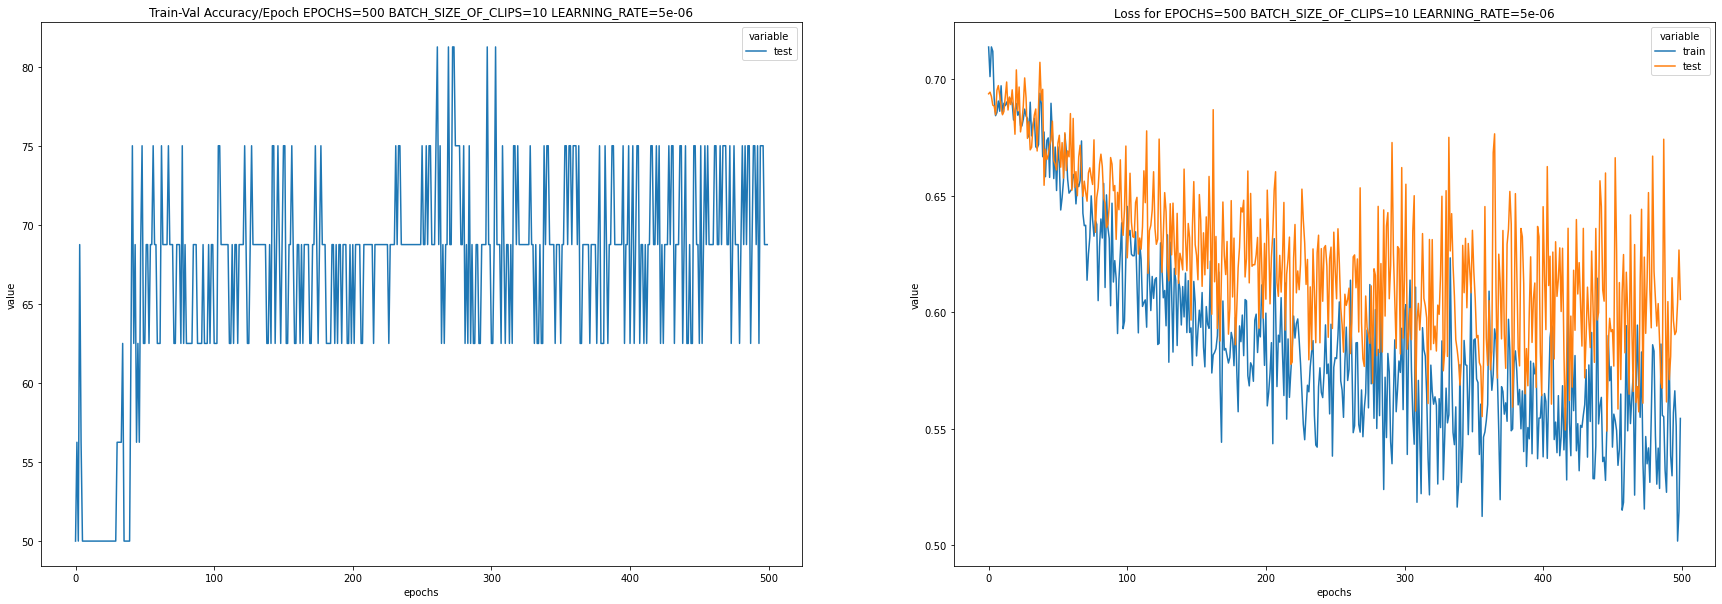

In [8]:

loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title(f'Loss for EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} LEARNING_RATE={LEARNING_RATE}')
sns.lineplot(data=acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title(f'Train-Val Accuracy/Epoch EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} LEARNING_RATE={LEARNING_RATE}')


                     


## 3. Evaluate the model on test dataset

In [9]:
model.load_state_dict(torch.load(
    os.path.join(model_path, "metric_model.pth")))
model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(test_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
        
print(f'y_pred_list{y_pred_list}')
print(f'y_true_list{y_true_list}')





 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([10, 60, 1, 128, 128])
   y_train_batch.size(): torch.Size([10])
 BATCH_OF_CLIPS_INDEX: 1 
   X_train_batch.size(): torch.Size([4, 60, 1, 128, 128])
   y_train_batch.size(): torch.Size([4])
y_pred_list[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]
y_true_list[1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]


              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.55      1.00      0.71         6

    accuracy                           0.64        14
   macro avg       0.77      0.69      0.63        14
weighted avg       0.81      0.64      0.61        14

[[3 5]
 [0 6]]


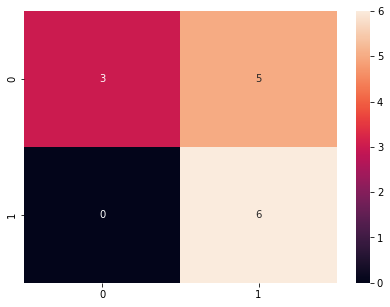

In [10]:

print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list))

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
plt.show()


## Cleanup data directory
Remove directory if a temporary was used.

In [11]:
if model_path is None:
   shutil.rmtree(model_path)


In [12]:

## CODE BLURS 


## SAMPLERS
# #SubsetRandomSampler(train_idx)
# train_sampler = Data.WeightedRandomSampler(weights=[0.1, 2.0, 3.2, 3.0, 0.6], num_samples=2, replacement=True)
# print( list(train_sampler) )
# #Data.WeightedRandomSampler(weights=samp_weights_v, num_samples = n_output_classes, replacement=True)

# ##Batch size is the number of frames for one segment and those frames can be set to suffle 
# train_dataloader = DataLoader(
#     dataset=data_clip00,
#     batch_size=30,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=False,
#     sampler=train_sampler
#     )

## MODELS 
#model = TestNet()
##TODO https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
#model = models.vit_l_32(pretrained=False) #has no attribute
#model = models.densenet121(pretrained=False) #has no attribute
#model = models.alexNet(pretrained=False)
#model = models.resnet50(pretrained=True)

